### Intro

Akan dilakukan visualisasi untuk kebutuhan *benchmarking* performa *execution time* antar pendekatan iteratif dan pendekatan rekursif dari algoritma *NON-OVERLAPPING-TIME-INTERVALS* dengan pendekatan yang **lebih komprehensif** berdasarkan perspektif kelas algoritma yang cenderung dikontruksi sebagai *multivariate function* secara kondisi rata-rata (*nC*, *nM*, dan *Waktu Eksekusi*). Visualisasi ini dibawa ke dalam format dua dimensi yang memudahkan, yakni *heatmap visualization*.

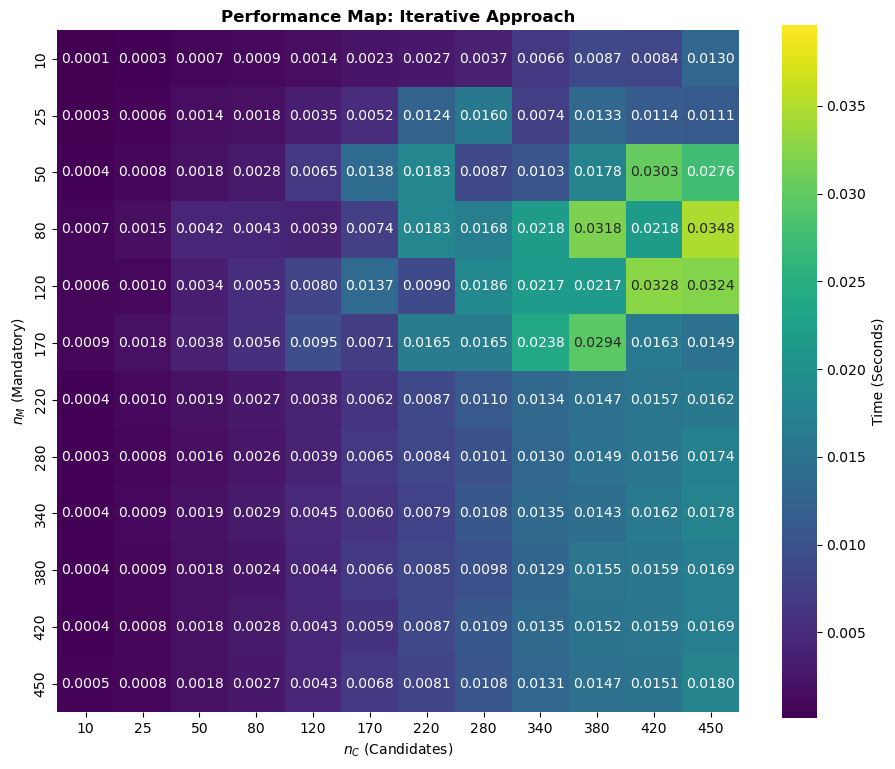

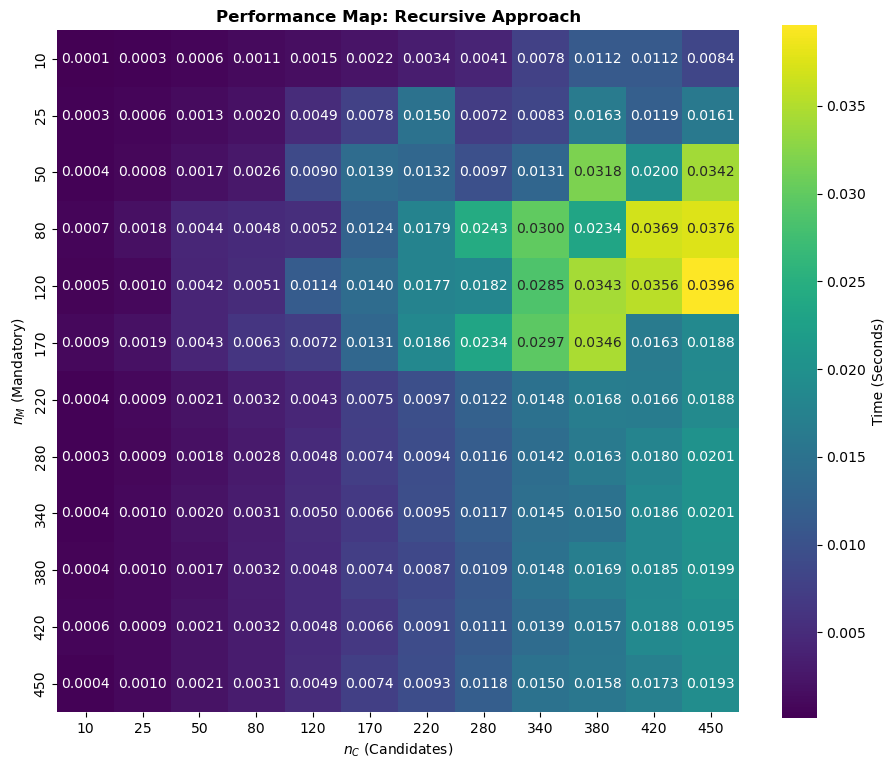

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import time
from algorithms.iterative import get_conflict_free_activities_iterative
from algorithms.recursive import get_conflict_free_activities_recursive
from data.generator import generate_activities

# increase recursion limit for big nC & nM sizes
sys.setrecursionlimit(10000)

# define nC and nM size range
n_range = [10, 25, 50, 80, 120, 170, 220, 280, 340, 380, 420, 450]
max_n = n_range[-1]

# number of repetitions per cell (Averaging)
NUM_RUNS = 3

# data pooling
full_candidates_pool = generate_activities(max_n, False)
full_mandatory_pool = generate_activities(max_n, True)

# matrix result
results_iter = np.zeros((len(n_range), len(n_range)))
results_recur = np.zeros((len(n_range), len(n_range)))

for i, nm in enumerate(n_range):
    for j, nc in enumerate(n_range):
        # slicing from data pooling above
        # to make sure iteration consistency
        candidates = full_candidates_pool[:nc]
        mandatory = full_mandatory_pool[:nm]

        # iterative: execution time measurement
        iterative_execution_times = []
        for _ in range(NUM_RUNS):
            start_time = time.perf_counter()
            get_conflict_free_activities_iterative(candidates, mandatory)
            iterative_execution_times.append(time.perf_counter() - start_time)
        results_iter[i, j] = np.mean(iterative_execution_times)
        
        # recursive: execution time measurement
        try:
            recursive_execution_times = []
            for _ in range(NUM_RUNS):
                t0 = time.perf_counter()
                get_conflict_free_activities_recursive(candidates, mandatory, 0)
                recursive_execution_times.append(time.perf_counter() - t0)
            results_recur[i, j] = np.mean(recursive_execution_times)
        except RecursionError:
            results_recur[i, j] = np.nan
        
# ===========================
#         VISUALIZATION
# ===========================

# global color scale synchronization
v_max = max(np.nanmax(results_iter), np.nanmax(results_recur))
v_min = min(np.nanmin(results_iter), np.nanmin(results_recur))

# iterative heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(results_iter,
            fmt=".4f", 
            annot=True, 
            cmap="viridis", 
            xticklabels=n_range, 
            yticklabels=n_range,
            vmin=v_min, 
            vmax=v_max, 
            square=True,
            cbar_kws={'label': 'Time (Seconds)'}
            )
plt.title('Performance Map: Iterative Approach', fontweight='bold')
plt.xlabel('$n_C$ (Candidates)')
plt.ylabel('$n_M$ (Mandatory)')
plt.show()

# recursive heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(results_recur, 
            annot=True,
            fmt=".4f", 
            cmap="viridis", 
            xticklabels=n_range, 
            yticklabels=n_range,
            vmin=v_min, 
            vmax=v_max, 
            square=True,
            cbar_kws={'label': 'Time (Seconds)'}
            )
plt.title('Performance Map: Recursive Approach', fontweight='bold')
plt.xlabel('$n_C$ (Candidates)')
plt.ylabel('$n_M$ (Mandatory)')
plt.show()

In [32]:
# raw analytic by us :)

# ratio > 1 == recursive is slower
ratio_matrix = results_recur / results_iter
diff_matrix = results_recur - results_iter


total_scenarios = results_iter.size
recursive_slower_count = np.sum(results_recur > results_iter)
avg_ratio = np.mean(ratio_matrix)
max_ratio = np.nanmax(ratio_matrix)
min_ratio = np.nanmin(ratio_matrix)

# output insights
print("="*66)
print("HASIL ANALISIS KOMPARATIF: ITERATIF VS REKURSIF (Based on Heatmap)")
print("="*66)

print(f"Total Skenario Pengujian: {total_scenarios} Skenario atau Sel")
print(f"Jumlah Sel Rekursif > Iteratif      : {recursive_slower_count} dari {total_scenarios} sel")
print(f"Persentase Dominasi Efisiensi      : {(recursive_slower_count/total_scenarios)*100:.1f}%")
print("-" * 66)
print(f"Rata-rata Faktor Overhead Rekursif : {avg_ratio:.2f}x lebih lambat")
print(f"Rentang Overhead                   : {min_ratio:.2f}x s.d. {max_ratio:.2f}x")
print("="*66)

if avg_ratio > 1:
    print(f"Pendekatan rekursif secara konsisten menunjukkan waktu eksekusi yang lebih tinggi.")

HASIL ANALISIS KOMPARATIF: ITERATIF VS REKURSIF (Based on Heatmap)
Total Skenario Pengujian: 144 Skenario atau Sel
Jumlah Sel Rekursif > Iteratif      : 125 dari 144 sel
Persentase Dominasi Efisiensi      : 86.8%
------------------------------------------------------------------
Rata-rata Faktor Overhead Rekursif : 1.14x lebih lambat
Rentang Overhead                   : 0.45x s.d. 1.97x
Pendekatan rekursif secara konsisten menunjukkan waktu eksekusi yang lebih tinggi.


In [35]:
import pandas as pd

# anomaly identification
rows, cols = np.where(results_recur <= results_iter)
# fetch
anomaly_table = []
for r, c in zip(rows, cols):
    anomaly_table.append({
        'nM (Mandatory)': n_range[r],
        'nC (Candidates)': n_range[c],
        'Time (Rec vs Iter)': f"{results_recur[r, c]:.7f}s vs {results_iter[r, c]:.7f}s"
    })
# into df
df_19 = pd.DataFrame(anomaly_table)
# display proof
print("DATA ANOMALI")
print("-" * 60)
display(df_19)

DATA ANOMALI
------------------------------------------------------------


,nM (Mandatory),nC (Candidates),Time (Rec vs Iter)
0,10,50,0.0006277s vs 0.0006675s
1,10,170,0.0022163s vs 0.0022871s
2,10,450,0.0084384s vs 0.0129531s
3,25,50,0.0012606s vs 0.0013989s
4,25,280,0.0072143s vs 0.0160236s
5,50,25,0.0008120s vs 0.0008471s
6,50,50,0.0017357s vs 0.0018473s
7,50,80,0.0026052s vs 0.0027747s
8,50,220,0.0131757s vs 0.0182736s
9,50,420,0.0200034s vs 0.0303145s


Anomali pada 19 sel tersebut terjadi karena pada data kecil, biaya inisialisasi sistem mungkin saja lebih mendominasi daripada beban komputasi algoritma, sehingga faktor eksternal seperti interupsi kernel atau background process Python memicu fluktuasi hasil.